In [1]:
import torch
from torch.autograd import Variable
from torch import optim, nn
import matplotlib.pyplot as plt
import shutil

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from argparse import Namespace
from tqdm import tqdm
from PIL import Image
import pickle
import numpy as np
import time
import os

In [3]:
NUM_CLASSES = 43
IMG_SIZE = 32

In [4]:
params = Namespace()
params.data = './data'
params.lr = 0.0001
params.batch_size = 64
params.seed = 7
params.cnn = '100, 150, 250, 350'
params.locnet = '200,300,200'
params.locnet2 = None
params.locnet3 = '150,150,150'
params.st = True
params.resume = False
params.epochs = 15
params.patience = 10
params.dropout = 0.5
params.use_pickle = True
params.save_loc = "/scratch/as10656/"
params.outfile = 'gtsrb_kaggle.csv'
params.train_pickle = params.save_loc + '/train_balanced_preprocessed.p'
params.extra_debug = False

In [5]:
torch.cuda.manual_seed(params.seed)
torch.manual_seed(params.seed);

In [6]:
class TrafficSignsDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.from_numpy(images)
        self.images = self.images.permute(0, 3, 1, 2)
        self.labels = torch.LongTensor(labels.argmax(1))
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import exposure
from PIL import Image

import warnings 

class Utils:
    def __init__(self):
        self.train_data_transforms = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])
        self.val_data_transforms = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor()
        ])
        
    def load_pickled_data(self, file, columns):
        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))
    
    def get_dataset(self, params):
        if params.use_pickle:
            data_images, data_labels = self.load_pickled_data(params.train_pickle, ['features', 'labels'])
            train_images, val_images, train_labels, val_labels = train_test_split(data_images, 
                                                                                  data_labels, 
                                                                                  test_size=0.25) 
            return TrafficSignsDataset(train_images, train_labels), TrafficSignsDataset(val_images, val_labels)
        else:
            train_dataset = datasets.ImageFolder(params.data + '/train_images',
                                                 transform=self.train_data_transforms)
            val_dataset = datasets.ImageFolder(self.params.data + '/val_images',
                                               transform=self.val_data_transforms)
            return train_dataset, val_dataset
    
    def pickle_data(self, x, y, save_loc):
        print("Saving pickle at " + save_loc)
        save = {"features": x, "labels": y}
        
        with open(save_loc, "wb") as f:
            pickle.dump(save, f)
    
    def pickle_data_from_folder(self, data_folder, save_loc):
        if not os.path.isdir(data_folder):
            print("Data folder must be a folder and should contains sub folders for each label")
            return
        
        resize_transform = transforms.Resize((IMG_SIZE, IMG_SIZE))
        sub_folders = os.listdir(data_folder)
        
        count = 0
        for sub_folder in sub_folders:
            sub_folder = os.path.join(data_folder, sub_folder)

            if not os.path.isdir(sub_folder):
                continue
            label = int(sub_folder.split("/")[-1])

            for image in os.listdir(sub_folder):
                count += 1

        save = {"features": np.empty([count, IMG_SIZE, IMG_SIZE, 3], dtype=np.uint8), 
                "labels": np.empty([count], dtype=int)}
        i = 0
        for sub_folder in sub_folders:
            sub_folder = os.path.join(data_folder, sub_folder)

            if not os.path.isdir(sub_folder):
                continue
            label = int(sub_folder.split("/")[-1])
            for image in os.listdir(sub_folder):
                image = os.path.join(sub_folder, image)
                pic = Image.open(image)
                pic = resize_transform(pic)
                pic = np.array(pic)
                save["features"][i] = pic
                save["labels"][i] = label
                i += 1

        
        with open(save_loc, "wb") as f:
            pickle.dump(save, f)
    
    def get_dataset_from_file(self, file):
        data_images, data_labels = self.load_pickled_data(file, ['features', 'labels'])
        
        return TrafficSignsDataset(data_images, data_labels)

    def get_convnet_output_size(self, network, input_size=IMG_SIZE):
        input_size = input_size or IMG_SIZE

        if type(network) != list:
            network = [network]

        in_channels = network[0].conv.in_channels

        output = Variable(torch.ones(1, in_channels, input_size, input_size))
        output.require_grad = False
        for conv in network:
            output = conv.forward(output)

        return np.asscalar(np.prod(output.data.shape)), output.data.size()[2]
    def get_time_hhmmss(self, start = None):
        """
        Calculates time since `start` and formats as a string.
        """
        if start is None:
            return time.strftime("%Y/%m/%d %H:%M:%S")
        end = time.time()
        m, s = divmod(end - start, 60)
        h, m = divmod(m, 60)
        time_str = "%02d:%02d:%02d" % (h, m, s)
        return time_str 
    
        
    def save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        epoch = state['epoch']
        print("=> Saving model to %s" % filename)

        if is_best:
            print("=> The model just saved has performed best on validation set" +
                  " till now")
            shutil.copyfile(filename, 'model_best.pth.tar')
        
        return filename


    def load_checkpoint(self, resume):
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            
            if not torch.cuda.is_available():
                checkpoint = torch.load(resume, map_location=lambda storage, location: storage)
            else:
                checkpoint = torch.load(resume)
            print("=> loaded checkpoint '{}' (epoch {})"
                     .format(resume, checkpoint['epoch']))
            return checkpoint
        else:
            print("=> no checkpoint found at '{}'".format(resume))
            return None
    
    
    def preprocess_dataset(self, X, y=None, use_tqdm=True):
        # Convert to single channel Y
        X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
        
        # Scale
        X = (X / 255.).astype(np.float32)
        
        # Don't want to use tqdm while generating csv
        if use_tqdm:
            preprocess_range = tqdm(range(X.shape[0]))
        else:
            preprocess_range = range(X.shape[0])
            
        # Ignore warnings, see http://scikit-image.org/docs/dev/user_guide/data_types.html
        for i in preprocess_range:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                X[i] = exposure.equalize_adapthist(X[i])

        if y is not None:  
            # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
            y = np.eye(NUM_CLASSES)[y]
            X, y = shuffle(X, y)

        # Add a single grayscale channel
        X = X.reshape(X.shape + (1,)) 
        return X, y

utils = Utils()

In [8]:
from skimage.transform import rotate, warp, ProjectiveTransform
import random

class Extender:
    def __init__(self, data_images, data_labels, ratio=0.5, intensity=0.75):
        self.x = data_images
        self.y = data_labels
        self.intensity = intensity
        self.ratio = ratio
        
        # These classes can be horizontally flipped for new images
        # Contains yield sign, ice, traffic signals etc
        self.horizontally_flippable_classes = [11, 12, 13, 15, 17, 18, 
                                               22, 26, 30, 35]
        
        # These ones can vertically flipped for new images
        # Contains 30 limit, 80 limit, no vehicles
        self.vertically_flippable_classes = np.array([1, 5, 12, 15, 17])
        
        # These ones need to be flipped both vertically and horizontally
        # to get same image
        self.both_flippable = [32, 40]
        
        # These ones contains pair which first can be generated by 
        # horizontally flipping the other. For e.g turn left and 
        # turn right
        self.flip_exchangeable = np.array([
            (19, 20),
            (20, 19),
            (33, 34),
            (34, 33),
            (36, 37),
            (37, 36),
            (38, 39),
            (39, 38)
        ])
    
    def extend_and_balance(self, custom_counts=None):
        print("Extending and balancing dataset with intesity", self.intensity)
        x, y = self.flip()
        _, class_counts = np.unique(y, return_counts=True)
        max_count = max(class_counts)
        
        if custom_counts is None:
            total = max_count * NUM_CLASSES
        else:
            total = np.sum(custom_counts)
        
        x_balanced = np.empty([0, x.shape[1], x.shape[2], x.shape[3]],
                              dtype=np.float32)
        y_balanced = np.empty([0], dtype=y.dtype)
        
        for c, class_count in zip(range(NUM_CLASSES), tqdm(class_counts)):
            x_org = (x[y == c] / 255.).astype(np.float32)
            y_org = y[y == c]
            
            x_balanced = np.append(x_balanced, x_org, axis=0)
            
            max_count = max_count if custom_counts is None else custom_counts[c]
            for i in range(max_count // class_count):
                x_mod = self.rotate(x_org)
                x_mod = self.projection_transform(x_mod)
                x_balanced = np.append(x_balanced, x_mod, axis=0)
            
            if max_count % class_count > 0:
                x_mod = self.rotate(x_org[:(max_count % class_count)])
                x_mod = self.projection_transform(x_mod)
            
                x_balanced = np.append(x_balanced, x_mod, axis=0)
            
            extension = np.full(x_balanced.shape[0] - y_balanced.shape[0],
                                c, dtype=y_balanced.dtype)
            y_balanced = np.append(y_balanced, extension)
            
            del x_org
            del y_org
        
        return (x_balanced * 255).astype(np.uint8), y_balanced
    
    def flip(self):
        x = np.empty([0, self.x.shape[1], self.x.shape[2], 
                      self.x.shape[3]], 
                      dtype=self.x.dtype)
        y = np.empty([0], dtype=self.y.dtype)
        
        for c in range(NUM_CLASSES):
            # Add existing data
            x = np.append(x, self.x[self.y == c], axis=0)
            
            if c in self.horizontally_flippable_classes:
                # Flip columns and append
                x = np.append(x, self.x[self.y == c][:, :, ::-1, :], 
                              axis=0)
                
            if c in self.vertically_flippable_classes:
                # Flip rows and append
                x = np.append(x, self.x[self.y == c][:, ::-1, :, :],
                              axis=0)
            
            if c in self.flip_exchangeable[:, 0]:
                flip_c = self.flip_exchangeable[self.flip_exchangeable[:, 0] == c]
                flip_c = flip_c[0][1]
                
                # Flip other class horizontally 
                x = np.append(x, self.x[self.y == flip_c][:, :, ::-1, :], 
                              axis=0)
            
            if c in self.both_flippable:
                # Flip both rows and columns
                x = np.append(x, self.x[self.y == c][:, ::-1, ::-1, :],
                             axis=0)
            
            # Extend y now
            y = np.append(y, np.full(x.shape[0] - y.shape[0], c, 
                                     dtype=int))
        
        return (x, y)
    
    def rotate(self, x):
        indices = np.random.choice(x.shape[0], int(x.shape[0] * self.ratio),
                                   replace=False)
        
        # If we rotate more than 30 degrees, context is lost.
        change = 30. * self.intensity
        x_return = np.empty(x.shape, dtype=x.dtype)
        for i in indices:
            x_return[i] = rotate(x[i], random.uniform(-change, change), mode="edge")
        
        return x_return
    
    def projection_transform(self, x):
        image_size = x.shape[1]
        
        change = image_size * 0.3 * self.intensity
        
        x_return = np.empty(x.shape, dtype=x.dtype)
        
        indices = np.random.choice(x.shape[0], int(x.shape[0] * self.ratio),
                                   replace=False)
        for i in indices:
            changes = []
            for _ in range(8):
                changes.append(random.uniform(-change, change))
            
            transform = ProjectiveTransform()
            transform.estimate(np.array(
                (
                    (changes[0], changes[1]), # top left
                    (changes[2], image_size - changes[3]), # bottom left
                    (image_size - changes[4], changes[5]), # top right
                    (image_size - changes[6], image_size - changes[7]) # bottom right
                )), np.array(
                (
                    (0, 0),
                    (0, image_size),
                    (image_size, 0),
                    (image_size, image_size)
                ))
            )
            
            x_return[i] = warp(x[i], transform, output_shape=(image_size, image_size),
                        order=1, mode="edge")
        
        return x_return

Uncomment the block below and run for extended, balanced and preprocessed images generation

In [ ]:
"""
train_pickle_path = params.save_loc + "/train.p"
# utils.pickle_data_from_folder(params.data + "train_images", train_pickle_path)
# x, y = utils.load_pickled_data(train_pickle_path, ["features", "labels"])
# print(x.shape)
extender = Extender(x, y, 1, 0.75)
x_extended, y_extended = extender.flip()
utils.pickle_data(x_extended, y_extended, params.save_loc + "train_extended.p")

# Generate 10k augmented plus original images for each class
x_balanced, y_balanced = extender.extend_and_balance(custom_counts=np.array([10000] * NUM_CLASSES))
utils.pickle_data(x_balanced, y_balanced, params.save_loc + "train_balanced.p")

x_preprocessed, y_preprocessed = utils.preprocess_dataset(x_balanced, y_balanced)
utils.pickle_data(x_preprocessed, y_preprocessed, params.save_loc + "train_balanced_preprocessed.p")
"""

  1%|▏         | 9607/695980 [01:30<1:47:16, 106.64it/s]

Only run the block below if we are preprocessing in the above block

In [ ]:
# View and run only after above
"""
plt.imshow(x_preprocessed[-21000].reshape(32, 32), cmap="gray")
plt.show()
"""
# Would be different as preprocessed was shuffled
"""
plt.imshow(x_balanced[-21000])
plt.show()
"""

In [9]:
class ConvNet(nn.Module):

    def __init__(self, in_c, out_c,
                 kernel_size,
                 padding_size='same',
                 pool_stride=2,
                 batch_norm=True):
        super().__init__()

        if padding_size == 'same':
            padding_size = kernel_size // 2
        self.conv = nn.Conv2d(in_c, out_c, kernel_size, padding=padding_size)
        self.max_pool2d = nn.MaxPool2d(pool_stride, stride=pool_stride)
        self.batch_norm = batch_norm
        self.batch_norm_2d = nn.BatchNorm2d(out_c)

    def forward(self, x):
        x = self.max_pool2d(nn.functional.leaky_relu(self.conv(x)))

        if self.batch_norm:
            return self.batch_norm_2d(x)
        else:
            return x

In [10]:
class Classifier(nn.Module):
    def __init__(self, input_nbr, out_nbr):
        super(Classifier, self).__init__()
        self.input_nbr = input_nbr
        self.lin = nn.Linear(input_nbr, out_nbr)

    def forward(self, x):
        return self.lin(x)

In [11]:
class SoftMaxClassifier(Classifier):
    def __init__(self, in_len, out_len):
        super().__init__(in_len, out_len)

    def forward(self, x):
        x = super().forward(x)
        return nn.functional.log_softmax(x)


In [12]:
class FullyConnected(nn.Module):
    def __init__(self, input_nbr, out_nbr):
        super(FullyConnected, self).__init__()
        self.input_nbr = input_nbr
        self.lin = nn.Linear(input_nbr, out_nbr)
        self.rel = nn.LeakyReLU()
        self.dropout = nn.Dropout()

    def forward(self, input):
        return self.dropout(self.rel(self.lin(input)))

In [13]:
class LocalizationNetwork(nn.Module):
    nbr_params = 6
    init_bias = torch.Tensor([1, 0, 0, 0, 1, 0])

    def __init__(self, conv_params, kernel_sizes,
                 input_size, input_channels=1):
        super(LocalizationNetwork, self).__init__()

        if not kernel_sizes:
            kernel_sizes = [5, 5]

        if len(kernel_sizes) != 2:
            raise Exception("Number of kernel sizes != 2")

        self.conv1 = ConvNet(input_channels, conv_params[0],
                             kernel_size=kernel_sizes[0],
                             batch_norm=False)
        self.conv2 = ConvNet(conv_params[0], conv_params[1],
                             kernel_size=kernel_sizes[1],
                             batch_norm=False)
        conv_output_size, _ = utils.get_convnet_output_size([self.conv1, self.conv2],
                                                            input_size)

        self.fc = FullyConnected(conv_output_size, conv_params[2])
        self.classifier = Classifier(conv_params[2], self.nbr_params)

        self.classifier.lin.weight.data.fill_(0)
        self.classifier.lin.bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])
        self.dropout = nn.Dropout2d()

    def forward(self, x):
        x = self.dropout(self.conv1(x))
        conv_output = self.dropout(self.conv2(x))
        conv_output = conv_output.view(conv_output.size()[0], -1)
        return self.classifier(self.fc(conv_output))

In [14]:
class SpatialTransformerNetwork(nn.Module):
    def __init__(self, params, kernel_sizes, input_size=IMG_SIZE,
                 input_channels=1):
        super(SpatialTransformerNetwork, self).__init__()
        self.localization_network = LocalizationNetwork(params,
                                                        kernel_sizes,
                                                        input_size,
                                                        input_channels)

    def forward(self, input):
        out = self.localization_network(input)
        out = out.view(out.size()[0], 2, 3)
        grid = nn.functional.affine_grid(out, input.size())
        return nn.functional.grid_sample(input, grid)


In [15]:
class GeneralNetwork(nn.Module):
    def __init__(self, opt):
        super(GeneralNetwork, self).__init__()

        if not opt.cnn:
            opt.cnn = '100, 150, 250, 350'
        self.kernel_sizes = [5, 3, 1]
        conv_params = list(map(int, opt.cnn.split(",")))

        self.conv1 = ConvNet(1, conv_params[0], kernel_size=self.kernel_sizes[0],
                             padding_size=0)
        self.conv2 = ConvNet(conv_params[0], conv_params[1],
                             kernel_size=self.kernel_sizes[1],
                             padding_size=0)

        conv_output_size, _ = utils.get_convnet_output_size([self.conv1, self.conv2])

        self.fc = FullyConnected(conv_output_size, conv_params[2])
        self.classifier = SoftMaxClassifier(conv_params[2], NUM_CLASSES)

        self.locnet_1 = None
        if opt.st and opt.locnet:
            params = list(map(int, opt.locnet.split(",")))
            self.locnet_1 = SpatialTransformerNetwork(params,
                                                      kernel_sizes=[7, 5])

        self.locnet_2 = None
        if opt.st and opt.locnet2:
            params = list(map(int, opt.locnet2.split(",")))
            _, current_size = utils.get_convnet_output_size([self.conv1])
            self.locnet_2 = SpatialTransformerNetwork(params,
                                                      [5, 3],
                                                      current_size,
                                                      conv_params[0])
        self.dropout = nn.Dropout2d()

    def forward(self, x):
        if self.locnet_1:
            x = self.locnet_1(x)

        x = self.conv1(x)

        if self.locnet_2:
            x = self.locnet_2(x)

        return self.classifier(self.fc(self.dropout(self.conv2(x))))

In [16]:
class IDSIANetwork(GeneralNetwork):
    def __init__(self, opt):
        super().__init__(opt)
        conv_params = list(map(int, opt.cnn.split(",")))

        self.conv3 = ConvNet(conv_params[1], conv_params[2], kernel_size=self.kernel_sizes[2],
                             padding_size=0)
        conv_output_size, _ = utils.get_convnet_output_size([self.conv1,
                                                      self.conv2,
                                                      self.conv3])
        self.fc = FullyConnected(conv_output_size, conv_params[3])
        self.classifier = SoftMaxClassifier(conv_params[3], NUM_CLASSES)

        self.locnet_3 = None
        if opt.st and opt.locnet3:
            params = list(map(int, opt.locnet3.split(",")))
            _, current_size = utils.get_convnet_output_size([self.conv1, self.conv2])
            self.locnet_3 = SpatialTransformerNetwork(params,
                                                      [3, 3],
                                                      current_size,
                                                      conv_params[1])

    def forward(self, x):
        if self.locnet_1:
            x = self.locnet_1(x)

        x = self.conv1(x)
        x = self.dropout(x)

        if self.locnet_2:
            x = self.locnet_2(x)

        x = self.conv2(x)
        x = self.dropout(x)

        if self.locnet_3:
            x = self.locnet_3(x)

        x = self.conv3(x)
        x = self.dropout(x)

        x = x.view(x.size()[0], -1)
        return self.classifier(self.fc(x))

In [17]:
class EarlyStopping(object):
    def __init__(self, model, optimizer, params=None, patience=100, minimize=True):
        self.minimize = minimize
        self.patience = patience
        self.model = model
        self.optimizer = optimizer
        self.params = params
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_acc = 0. if minimize else np.inf
        self.best_monitored_epoch = 0

        self.restore_path = None

    def __call__(self, value, acc, epoch, rest):
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.best_monitored_acc = acc

            state = {
                'params': self.params,
                'epoch': self.best_monitored_epoch,
                'state_dict': self.model.state_dict(),
                'best': self.best_monitored_value,
                'best_acc': self.best_monitored_acc,
                'optimizer': self.optimizer.state_dict(),
            }

            rest.update(state)
            print(value, acc)
            self.restore_path = utils.save_checkpoint(
                rest, True, os.path.join(self.params.save_loc, "early_stopping_checkpoint"))
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path is not None:
                checkpoint = utils.load_checkpoint(self.restore_path)
                self.best_monitored_value = checkpoint['best']
                self.best_monitored_acc = checkpoint['best_acc']
                self.best_monitored_epoch = checkpoint['epoch']
                self.model.load_state_dict(checkpoint['state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer'])
            else:
                print("ERROR: Failed to restore session")
            return True

        return False

    def init_from_checkpoint(self, checkpoint):
        self.best_monitored_value = checkpoint['best']
        self.best_monitored_acc = checkpoint['best_acc']
        self.best_monitored_epoch = 0

        if "params" in checkpoint:
            self.params = checkpoint['params']

    def print_info(self):
        print("Best loss: {0}, Best Accuracy: {1}, at epoch {2}"
              .format(self.best_monitored_value,
                      self.best_monitored_acc,
                      self.best_monitored_epoch))


In [18]:
class Plotter:
    def plot_curve(self, sub_plot, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
        train_values = params[train_column]
        valid_values = params[valid_column]
        epochs = train_values.shape[0]
        x_axis = np.arange(epochs)
        sub_plot.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
        sub_plot.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
        return epochs

    # Plot history curves
    def plot_learning_curves(self, params):
        curves_figure = plt.figure(figsize = (10, 4))
        sub_plot = curves_figure.add_subplot(1, 2, 1)
        epochs_plotted = self.plot_curve(sub_plot, params, train_column = "train_acc", valid_column = "val_acc")

        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.xlim(0, epochs_plotted)

        sub_plot = curves_figure.add_subplot(1, 2, 2)
        epochs_plotted = self.plot_curve(sub_plot, params, train_column = "train_loss", valid_column = "val_loss")

        plt.grid()
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.xlim(0, epochs_plotted)
        plt.yscale("log")
plotter = Plotter()

In [21]:
class Trainer:
    def __init__(self, params, train_data=None, val_data=None):
        self.params = params
        self.train_data = train_data
        self.val_data = val_data

        print("Creating dataloaders")
        self.cuda_available = torch.cuda.is_available()

        if self.train_data is not None:
            self.train_loader = DataLoader(dataset=self.train_data,
                                           shuffle=True,
                                           batch_size=params.batch_size,
                                           pin_memory=self.cuda_available)
        if self.val_data is not None:
            self.val_loader = DataLoader(dataset=self.val_data,
                                         shuffle=False,
                                         batch_size=params.batch_size,
                                         pin_memory=self.cuda_available)

        self.string_fixer = "=========="

    def load(self):
        print("Loading model")
        self.model = IDSIANetwork(self.params)
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                           self.model.parameters()),
                                    lr=self.params.lr)

        self.start_time = time.time()
        self.histories = {
            "train_loss": np.empty(0, dtype=np.float32),
            "train_acc": np.empty(0, dtype=np.float32),
            "val_loss": np.empty(0, dtype=np.float32),
            "val_acc": np.empty(0, dtype=np.float32)
        }

        # We minimize the cross entropy loss here
        self.early_stopping = EarlyStopping(
            self.model, self.optimizer, params=self.params,
            patience=self.params.patience, minimize=True)

        if self.params.resume:
            checkpoint = utils.load_checkpoint(self.params.resume)
            if checkpoint is not None:

                if "params" in checkpoint:
                    # To make sure model architecture remains same
                    self.params.locnet = checkpoint['params'].locnet
                    self.params.locnet2 = checkpoint['params'].locnet2
                    self.params.locnet3 = checkpoint['params'].locnet3
                    self.params.st = checkpoint['params'].st

                    self.model = IDSIANetwork(self.params)
                    self.optimizer = optim.Adam(filter(lambda p: p.requires_grad,
                                                       self.model.parameters()),
                                                lr=self.params.lr)

                self.model.load_state_dict(checkpoint['state_dict'])
                
                self.optimizer.load_state_dict(checkpoint['optimizer'])
                self.histories.update(checkpoint)
                self.early_stopping.init_from_checkpoint(checkpoint)
                print("Loaded model, Best Loss: %.8f, Best Acc: %.2f" %
                      (checkpoint['best'], checkpoint['best_acc']))

        if self.cuda_available:
            self.model = self.model.cuda()

    def train(self):
        self.epochs = self.params.epochs

        criterion = nn.CrossEntropyLoss()
        start_epoch = 0

        self.model.train()
        print("Starting training")
        self.print_info()
        for epoch in range(start_epoch, self.params.epochs):
            for i, (images, labels) in enumerate(self.train_loader):
                images_batch = Variable(images)
                labels_batch = Variable(labels)

                if self.cuda_available:
                    images_batch = images_batch.cuda()
                    labels_batch = labels_batch.cuda(async=True)

                self.optimizer.zero_grad()
                output = self.model(images_batch)
                loss = criterion(output, labels_batch.long())
                loss.backward()
                self.optimizer.step()

                if self.params.extra_debug and (i + 1) % (self.params.batch_size * 4) == 0:
                    print(('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4},')
                          .format(epoch + 1,
                                  self.params.epochs,
                                  i + 1,
                                  len(self.train_loader),
                                  loss.data[0]))

            train_acc, train_loss = self.validate_model(self.train_loader, self.model)
            val_acc, val_loss = self.validate_model(self.val_loader, self.model)

            self.histories['train_loss'] = np.append(self.histories['train_loss'], [train_loss])
            self.histories['val_loss'] = np.append(self.histories['val_loss'], [val_loss])
            self.histories['val_acc'] = np.append(self.histories['val_acc'], [val_acc])
            self.histories['train_acc'] = np.append(self.histories['train_acc'], [train_acc])

            if not self.early_stopping(val_loss, val_acc, epoch, self.histories):
                self.print_train_info(epoch, train_acc, train_loss, val_acc, val_loss)
            else:
                print("Early stopping activated")
                print("Restoring earlier state and stopping")
                self.early_stopping.print_info()
                break

    def validate_model(self, loader, model):
        model.eval()
        correct = 0
        total = 0
        total_loss = 0

        for images, labels in loader:
            images_batch = Variable(images, volatile=True)
            labels_batch = Variable(labels.long())

            if self.cuda_available:
                images_batch = images_batch.cuda()
                labels_batch = labels_batch.cuda()

            output = model(images_batch)
            loss = nn.functional.cross_entropy(output, labels_batch.long(), size_average=False)
            total_loss += loss.data[0]
            total += len(labels_batch)

            if not self.cuda_available:
                correct += (labels_batch == output.max(1)[1]).data.cpu().numpy().sum()
            else:
                correct += (labels_batch == output.max(1)[1]).data.sum()
        model.train()

        average_loss = total_loss / total
        return correct / total * 100, average_loss

    def print_info(self):
        print(self.string_fixer + " Data " + self.string_fixer)
        print("Training set: %d examples" % (len(self.train_data)))
        print("Validation set: %d examples" % (len(self.val_data)))
        print("Timestamp: %s" % utils.get_time_hhmmss())

        print(self.string_fixer + " Params " + self.string_fixer)

        print("Learning Rate: %f" % self.params.lr)
        print("Dropout (p): %f" % self.params.dropout)
        print("Batch Size: %d" % self.params.batch_size)
        print("Epochs: %d" % self.params.epochs)
        print("Patience: %d" % self.params.patience)
        print("Resume: %s" % self.params.resume)

    def print_train_info(self, epoch, train_acc, train_loss, val_acc, val_loss):
        print((self.string_fixer + " Epoch: {0}/{1} " + self.string_fixer)
              .format(epoch + 1, self.params.epochs))
#         print("Train Loss: %.8f, Train Acc: %.2f" % (train_loss, train_acc))
        print("Validation Loss: %.8f, Validation Acc: %.2f" % (val_loss, val_acc))
        self.early_stopping.print_info()
        print("Elapsed Time: %s" % (utils.get_time_hhmmss(self.start_time)))
        print("Current timestamp: %s" % (utils.get_time_hhmmss()))


In [50]:
train_dataset, val_dataset = utils.get_dataset(params)

Train first time with train pickle mentioned in params, should be extended to let the model now about the real distribution

In [ ]:
params.resume = False
params.extra_debug = False
trainer = Trainer(params, train_dataset, val_dataset)
trainer.load()

In [ ]:
trainer.train()

Here we append all of the data together and retrain to achieve better validation accuracy

In [21]:
x, y = utils.load_pickled_data(params.save_loc + 'train_extended_preprocessed.p', ["features", "labels"])
x_load, y_load = utils.load_pickled_data(params.save_loc + 'train_balanced_preprocessed.p', ["features", "labels"])
x = np.append(x, x_load, axis=0)
y = np.append(y, y_load, axis=0)

x_load, y_load = utils.load_pickled_data(params.save_loc + 'train_balanced_preprocessed_0.5.p', ["features", "labels"])
x = np.append(x, x_load, axis=0)
y = np.append(y, y_load, axis=0)

x_load, y_load = utils.load_pickled_data(params.save_loc + 'train_balanced_preprocessed_0.25.p', ["features", "labels"])
x = np.append(x, x_load, axis=0)
y = np.append(y, y_load, axis=0)

x_load, y_load = utils.load_pickled_data(params.save_loc + 'train_balanced_preprocessed_0.10.p', ["features", "labels"])
x = np.append(x, x_load, axis=0)
y = np.append(y, y_load, axis=0)

x_load, y_load = utils.load_pickled_data(params.save_loc + 'train_balanced_preprocessed_0.05.p', ["features", "labels"])
x = np.append(x, x_load, axis=0)
y = np.append(y, y_load, axis=0)

train_images, val_images, train_labels, val_labels = train_test_split(x, y, test_size=0.25) 
train_dataset, val_dataset = TrafficSignsDataset(train_images, train_labels), TrafficSignsDataset(val_images, val_labels)

In [ ]:
params.resume = params.save_loc + "early_stopping_checkpoint"
params.epochs = 30
params.patience = 10
params.extra_debug = True
trainer = None
trainer = Trainer(params, train_dataset, val_dataset)
trainer.load()
trainer.train()

In [61]:
plotter.plot_learning_curves(trainer.histories)

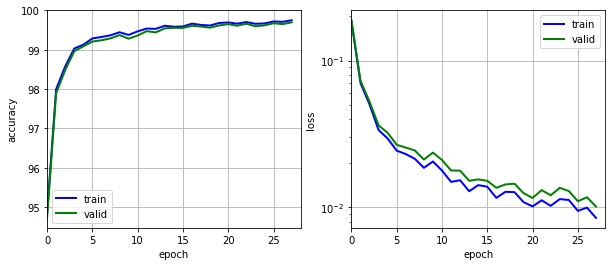

In [62]:
plt.show()

In [22]:
# Generate the CSV
test_dir = params.data + '/test_images'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

output_file = open(params.outfile, "w")
output_file.write("Filename,ClassId\n")
trainer.model.eval()
for f in tqdm(os.listdir(test_dir)):
    if 'ppm' in f:
        data = utils.val_data_transforms(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = data.permute(0, 3, 2, 1)
        data, _ = utils.preprocess_dataset(data.numpy(), use_tqdm=False)
        data = torch.from_numpy(data).permute(0, 3, 2, 1)
        data = Variable(data, volatile=True)
        data = data.cuda()
        output = trainer.model(data)
        pred = output.data.max(1, keepdim=True)[1]

        file_id = f[0:5]
        output_file.write("%s,%d\n" % (file_id, pred[0][0]))
trainer.model.train()
output_file.close()

100%|██████████| 12631/12631 [04:43<00:00, 44.51it/s]
